In [1]:
from collections import Counter
from dotenv import dotenv_values
from gpt4all import GPT4All
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora, models, similarities
from gensim.models.ldamulticore import LdaMulticore
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from langdetect import detect, DetectorFactory
import matplotlib.pyplot as plt
import pandas as pd
from langchain_community.llms import GPT4All
import seaborn as sns
from matplotlib import cm
import numpy as np
from tqdm import tqdm
from wordcloud import WordCloud
import nest_asyncio
import praw
from sklearn.manifold import TSNE
import re
import string

nest_asyncio.apply()

nltk.download("vader_lexicon")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

Reddit is the server that provides an API (Application Programming Interface).
PRAW is a Python library that acts as the client, meaning it communicates with Reddit's API on your behalf.

In [3]:
#env file has all the hidden credentials
config = dotenv_values(".env")

#reddit API praw library to collect r/<insert movie here> posts 
reddit = praw.Reddit(
    client_id = config['CLIENT_ID'],
    client_secret = config['CLIENT_SECRET'], 
    user_agent = config['USER_AGENT'],
)

In [4]:
def analyze_subreddits_sentiment(reddit_client, subreddits, post_limit=5000):
    global all_words, fdist, stopwords_list
    
    DetectorFactory.seed = 0  # make language detection deterministic
    vader = SentimentIntensityAnalyzer()
    
    # Prepare stopwords list
    additional_stopwords = ['https', 'i', 'com', 'http', 'rt', 'co', 'the', 'amp', 'lt', 'a', 'www', 'got', 'get', 
                            'ly', 'u', 'also', 'like', 'could', 'go', 'know', 'org', 'edu', 'cdn', 'img', 'jpg', 'png', 
                            'even','*']
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation) #adds punctuation if the punctuation was a token and not attached to a word
    stopwords_list += additional_stopwords
    stopwords_list = list(set([word.lower() for word in stopwords_list]))

    #from chatgpt because my stopwords list in the following function doesn't remove the puntuation properly
    #real tokenizer that separates punctuation from words
    def clean_and_tokenize(text):
        tokens = word_tokenize(text.lower())  # splits "version," into ["version", ","]
        tokens = [word for word in tokens if word.isalpha()]  # removes punctuation/numbers
        tokens = [word for word in tokens if word not in stopwords_list]
        return tokens

    combined_df = pd.DataFrame() #needed to accumulate all the dfs/movies that go through the for loop 
    all_words = []
    for subreddit_name in subreddits:
        subreddit = reddit_client.subreddit(subreddit_name)
        
        reviews = []
        for submission in subreddit.new(limit=post_limit):
            if submission.selftext:
                try:
                    if detect(submission.selftext) == 'en':
                        reviews.append(submission.selftext)
                except:
                    pass
        
        df = pd.DataFrame({'reviews': reviews})
        #column to show which subreddit the post pertains to 
        df['movie_subreddit'] = subreddit_name
        
        # Sentiment analysis with VADER
        df['positive_sentiment_score'] = df['reviews'].apply(lambda x: vader.polarity_scores(x)['pos'])
        df['negative_sentiment_score'] = df['reviews'].apply(lambda x: vader.polarity_scores(x)['neg'])
        df['neutral_sentiment_score'] = df['reviews'].apply(lambda x: vader.polarity_scores(x)['neu'])
        df['compound_sentiment_score'] = df['reviews'].apply(lambda x: vader.polarity_scores(x)['compound'])

        def classify_sentiment(score):
            if score >= 0.05:
                return 'positive'
            elif score <= -0.05:
                return 'negative'
            else:
                return 'neutral'
        
        df['sentiment'] = df['compound_sentiment_score'].apply(classify_sentiment)
        
        # Clean and tokenize
        df["filtered_review"] = df["reviews"].apply(clean_and_tokenize)

        # Add to combined dataframe
        combined_df = pd.concat([combined_df, df], ignore_index=True)
        
    return combined_df

In [5]:
# PRAW Reddit client called `reddit` as first argument
movie_subreddits = ['Inception', 'Wicked', 'ShawshankRedemption'] #'A Walk To Remember'
movies_df = analyze_subreddits_sentiment(reddit, movie_subreddits, post_limit=1000)

In [6]:
movies_df.head(2)

,reviews,movie_subreddit,positive_sentiment_score,negative_sentiment_score,neutral_sentiment_score,compound_sentiment_score,sentiment,filtered_review
0,"Peter Browning enters the room 528, but he's just a projection of Fishcer's mind. However, he confesses to kidnapping Fischer. Why is that?",Inception,0.000,0.00,1.000,0.0000,neutral,"[peter, browning, enters, room, projection, fishcer, mind, however, confesses, kidnapping, fischer]"
1,"So I was thinking about the fact that dreams are a lot less consistent than what was shown in the movie.\n\nIf the dreams in the movie were anything like real dreams, it'd be pretty much an incomprehensible mess, although it's important to note that they are still not 100% copy of reality.\n\nSo I think the machines are doing two things at once:\n\n\-Connecting all people to one dream \n\n\-Ensuring that at least the user's ""body"" in the dream has a consistent experience while dreaming\n\nThis also explains why in the movie, the users need totems. IRL people who practice lucid dreaming can just put their hands together and see if they go through each other. In a regular lucid dream, a person that has been shot could just choose to not feel the pain or to heal from the wounds and it would be fine, but not in Inception, because the machines don't allow the users to just change the state of their dream bodies. So the users need an external way of ensuring they are dreaming.",Inception,0.128,0.02,0.852,0.9178,positive,"[thinking, fact, dreams, lot, less, consistent, shown, movie, dreams, movie, anything, real, dreams, pretty, much, incomprehensible, mess, although, important, note, still, copy, reality, think, machines, two, things, people, one, dream, least, user, body, dream, consistent, experience, dreaming, explains, movie, users, need, totems, irl, people, practice, lucid, dreaming, put, hands, together, see, regular, lucid, dream, person, shot, choose, feel, pain, heal, wounds, would, fine, inception, machines, allow, users, change, state, dream, bodies, users, need, external, way, ensuring, dreaming]"


In [7]:
def freq_dist_for_group(group):
    global fdist, all_words #use object for graphs
    all_words = group['filtered_review'].explode() #takes tokens into a series 
    fdist = FreqDist(all_words) #NLTKs FreqDist counts how many times each word appears
    return fdist #dictionary 

fdist_series = movies_df.groupby('movie_subreddit').apply(freq_dist_for_group)

C:\Users\raize\AppData\Local\Temp\ipykernel_18588\4138339937.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fdist_series = movies_df.groupby('movie_subreddit').apply(freq_dist_for_group)


In [8]:
fdist_series
# fdist
# all_words[:7]

movie_subreddit
Inception              {'peter': 15, 'browning': 34, 'enters': 7, 'room': 19, 'projection': 27, 'fishcer': 1, 'mind': 65, 'however': 29, 'confesses': 1, 'kidnapping': 2, 'fischer': 170, 'thinking': 28, 'fact': 36, 'dreams': 94, 'lot': 33, 'less': 7, 'consistent': 3, 'shown': 12, 'movie': 330, 'anything': 26, 'real': 182, 'pretty': 17, 'much': 43, 'incomprehensible': 1, 'mess': 5, 'although': 13, 'important': 14, 'note': 2, 'still': 118, 'copy': 2, 'reality': 204, 'think': 148, 'machines': 4, 'two': 42, 'things': 43, 'people': 113, 'one': 176, 'dream': 638, 'least': 29, 'user': 3, 'body': 6, 'experience': 21, 'dreaming': 102, 'explains': 18, 'users': 3, 'need': 46, 'totems': 21, 'irl': 5, 'practice': 1, 'lucid': 10, 'put': 22, 'hands': 2, 'together': 24, 'see': 123, 'regular': 8, 'person': 44, 'shot': 22, 'choose': 6, 'feel': 41, 'pain': 2, 'heal': 2, 'wounds': 4, 'would': 293, 'fine': 8, 'inception': 236, 'allow': 9, 'change': 15, 'state': 18, 'bodies': 5, 'external': 1

In [9]:
for movie in movie_subreddits:
    fdist_movie = fdist_series[movie].most_common(10)
    print(fdist_movie)

[('cobb', 661), ('dream', 638), ('movie', 330), ('limbo', 318), ('mal', 307), ('would', 293), ('saito', 277), ('inception', 236), ('time', 225), ('level', 218)]
[('wicked', 354), ('elphaba', 320), ('glinda', 243), ('movie', 234), ('one', 201), ('would', 161), ('think', 157), ('see', 152), ('good', 140), ('musical', 125)]
[('andy', 60), ('movie', 36), ('red', 33), ('shawshank', 27), ('prison', 27), ('warden', 25), ('hope', 22), ('would', 19), ('life', 19), ('one', 18)]


In [10]:
# movie_subreddits = ['Inception', 'Wicked', 'ShawshankRedemption']
# movie_name_df = pd.DataFrame() #needed to accumulate all the dfs/movies that go through the for loop 
# for movie in movie_subreddits:
#     each_movie_df = movies_df[movies_df['movie_subreddit'] == movie]
#     movie_name_df = pd.concat([movie_name_df, each_movie_df], ignore_index=True)
# movie_name_df.head(2)

In [11]:
# movie_name_df.shape
# movie_name_df['movie_subreddit'].value_counts()

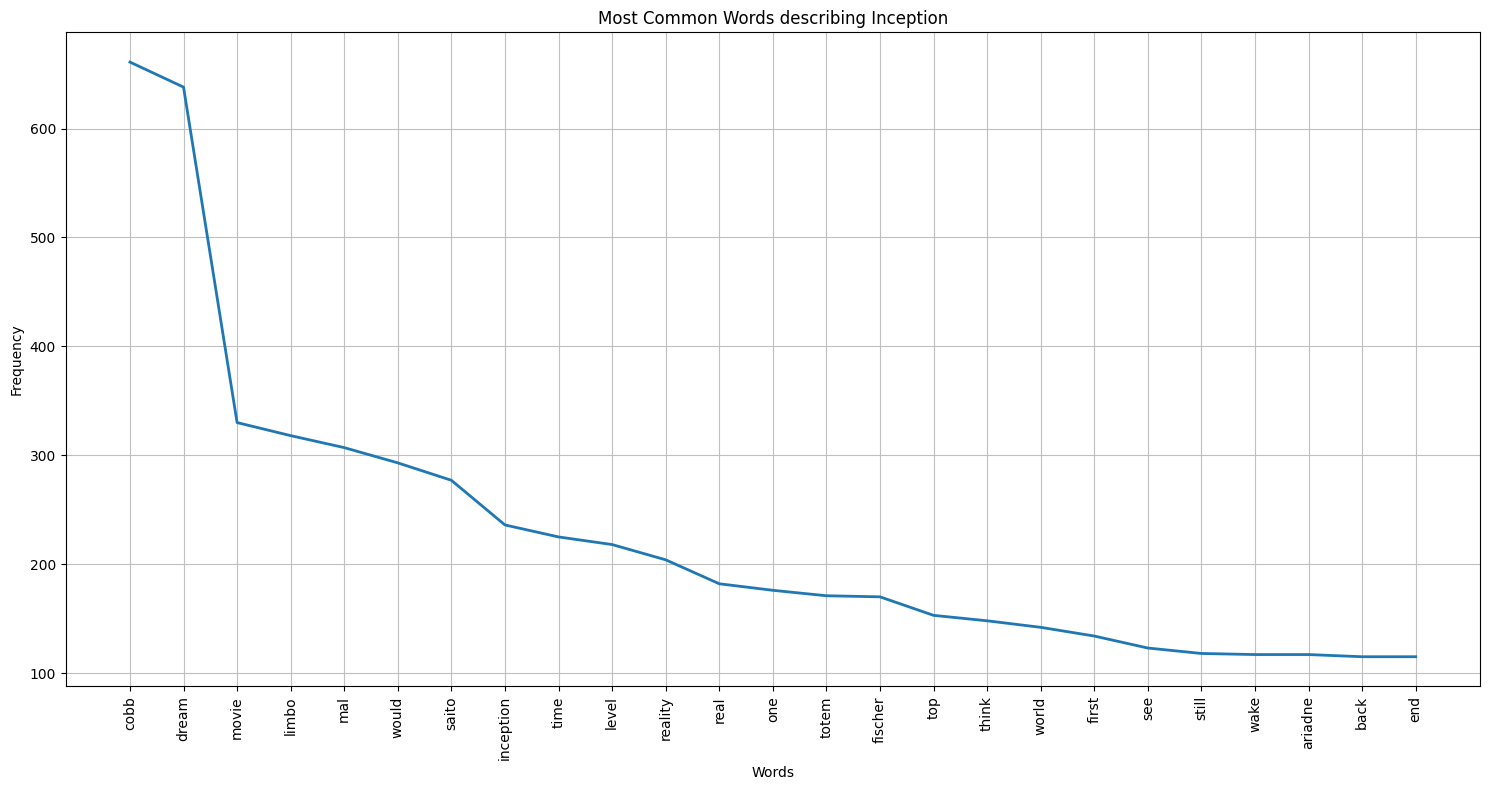

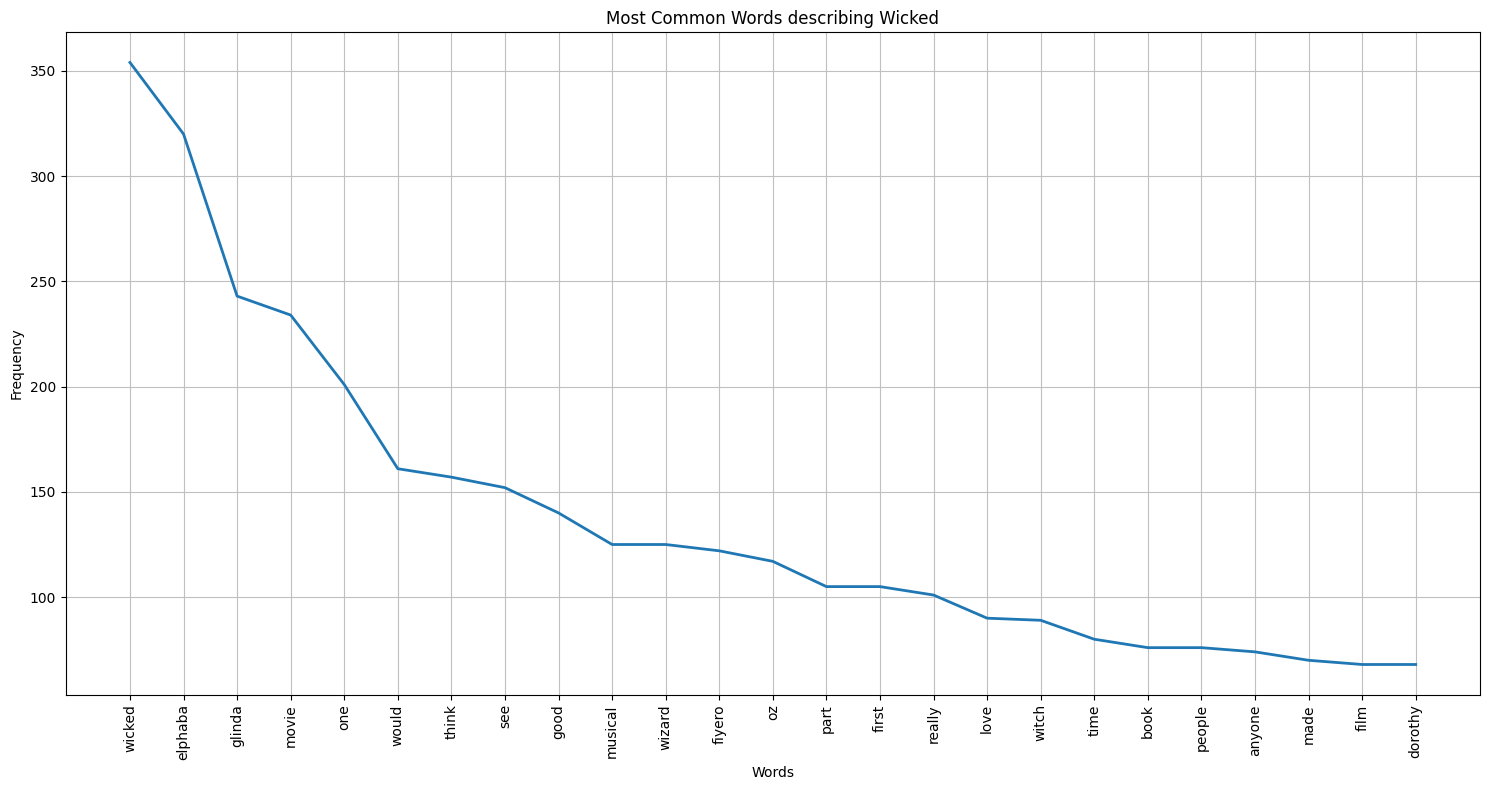

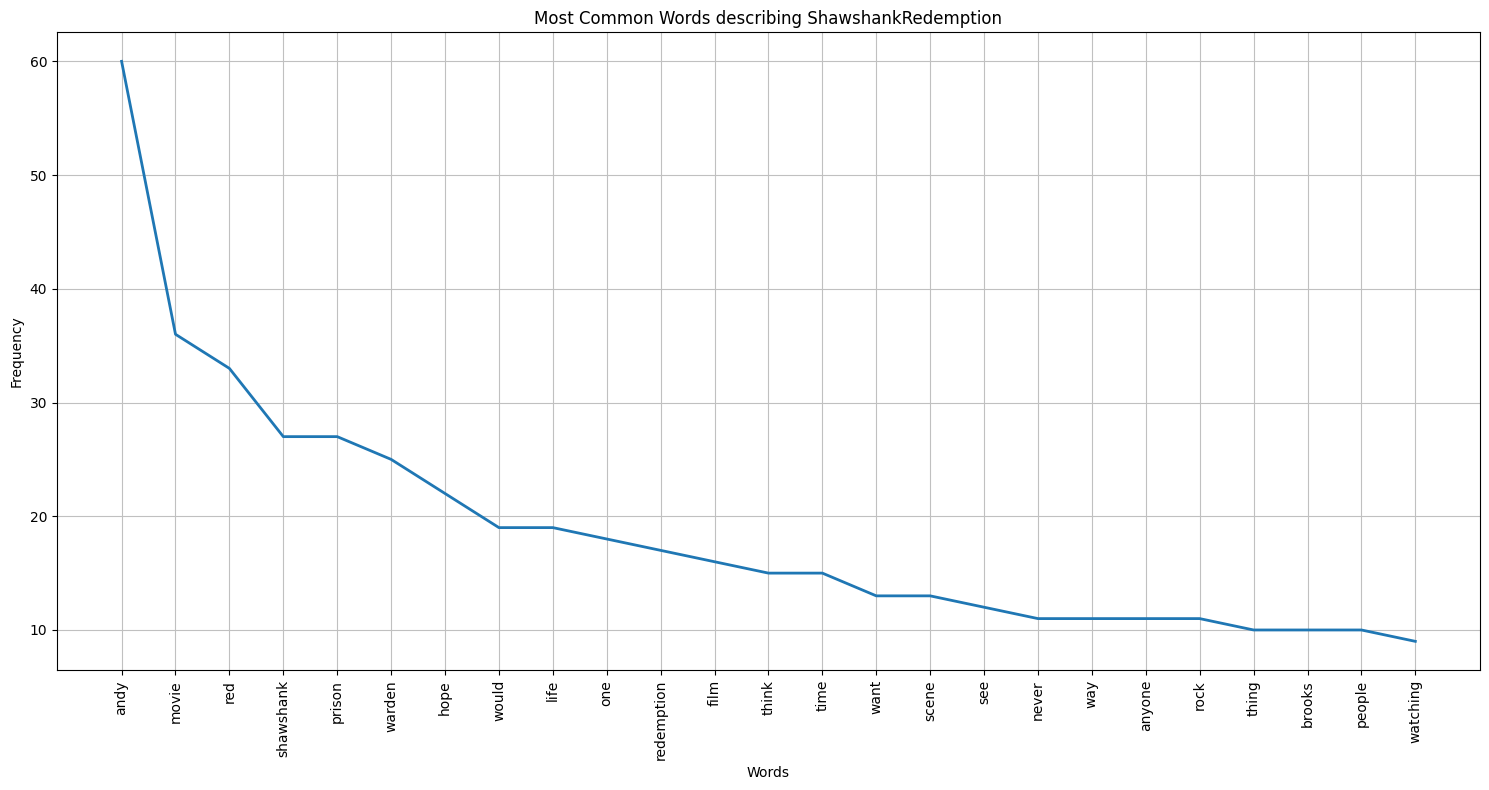

In [16]:
for movie in movie_subreddits:
    fdist_movie = fdist_series[movie]
    
    plt.figure(figsize=(15, 8))
    fdist_movie.plot(25)  # plot top 25 words
    plt.title('Most Common Words describing ' + movie)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig('images/' + movie + '_freqlinegraph.png')
    plt.show()

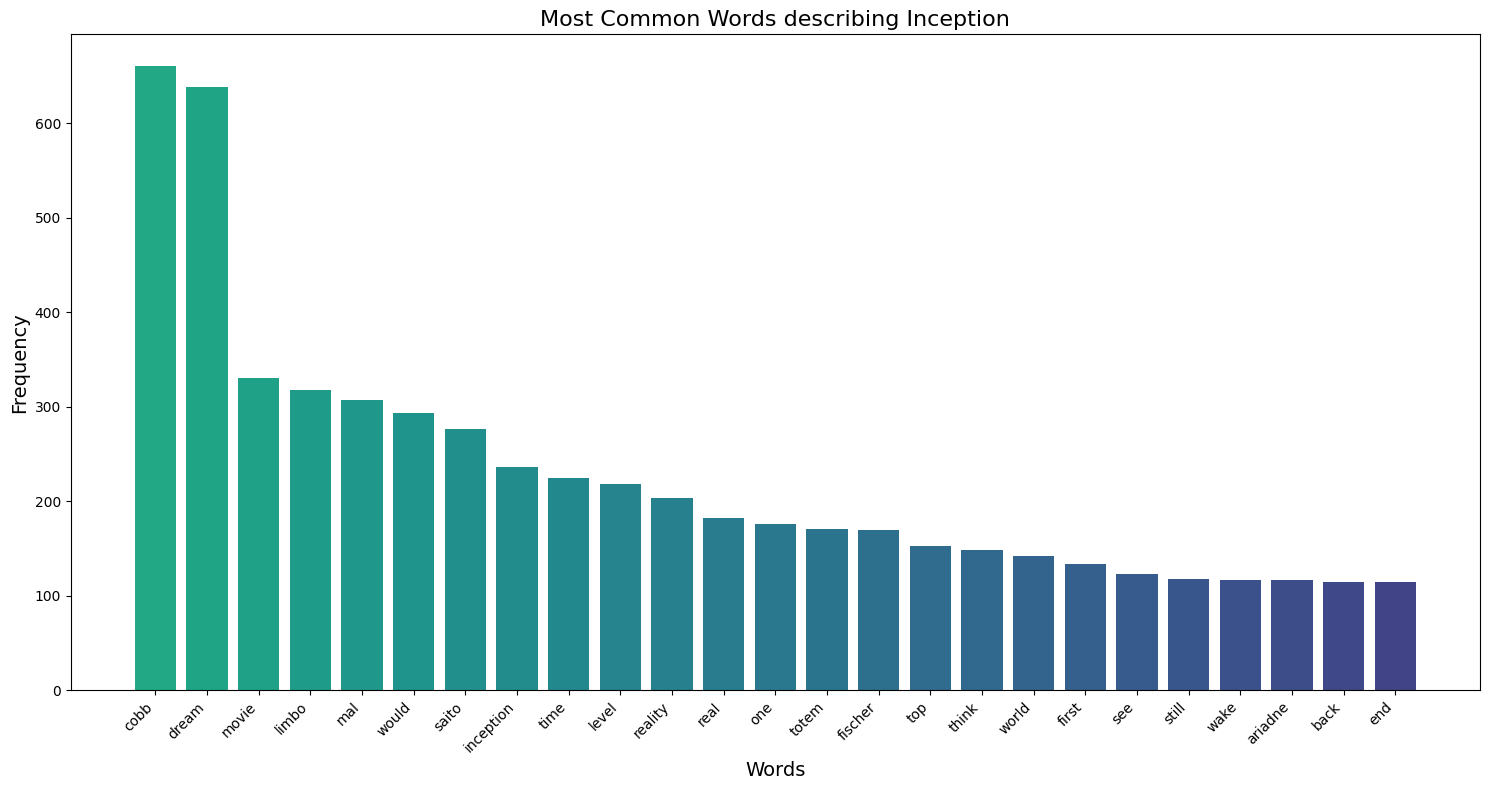

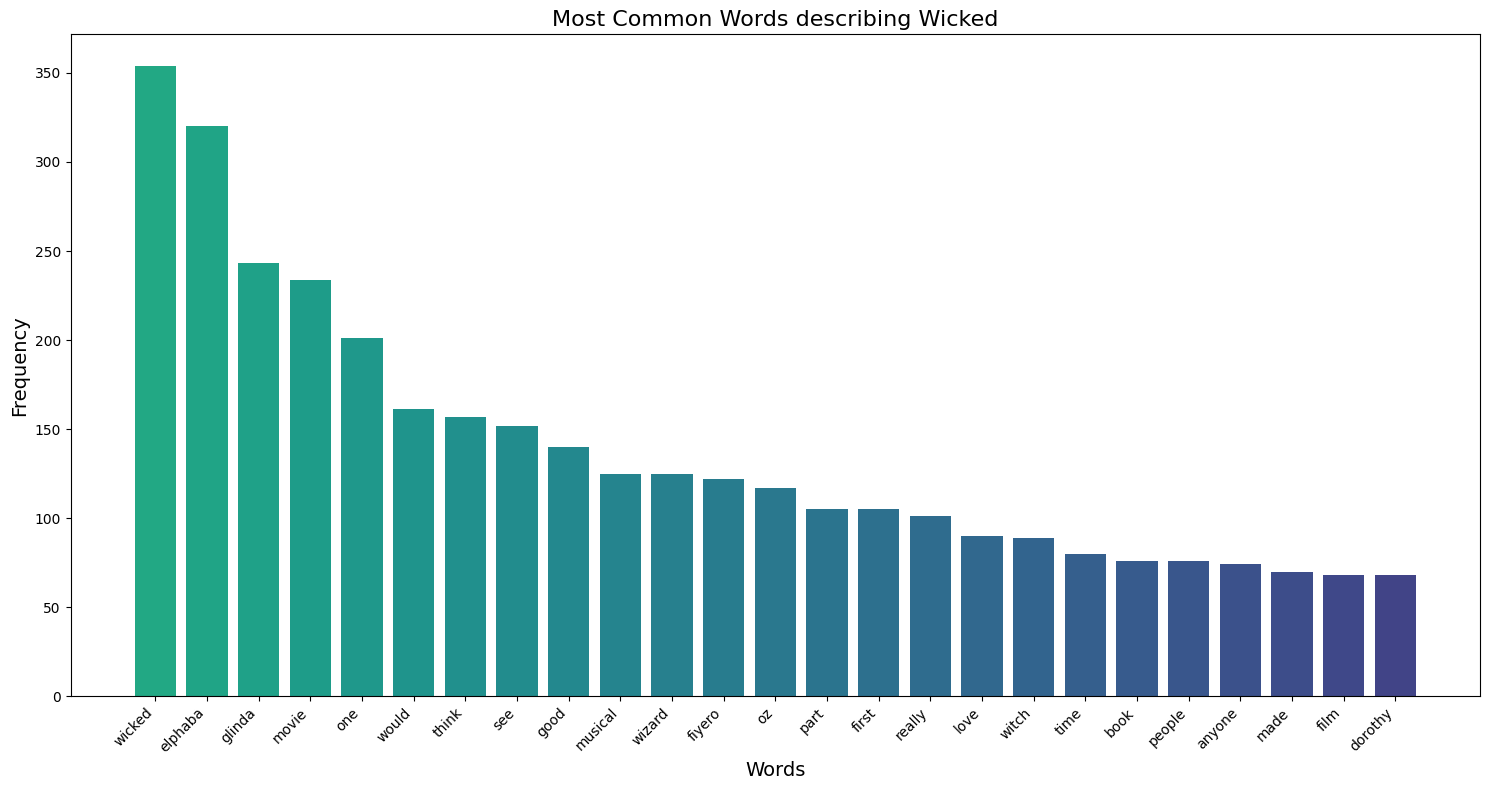

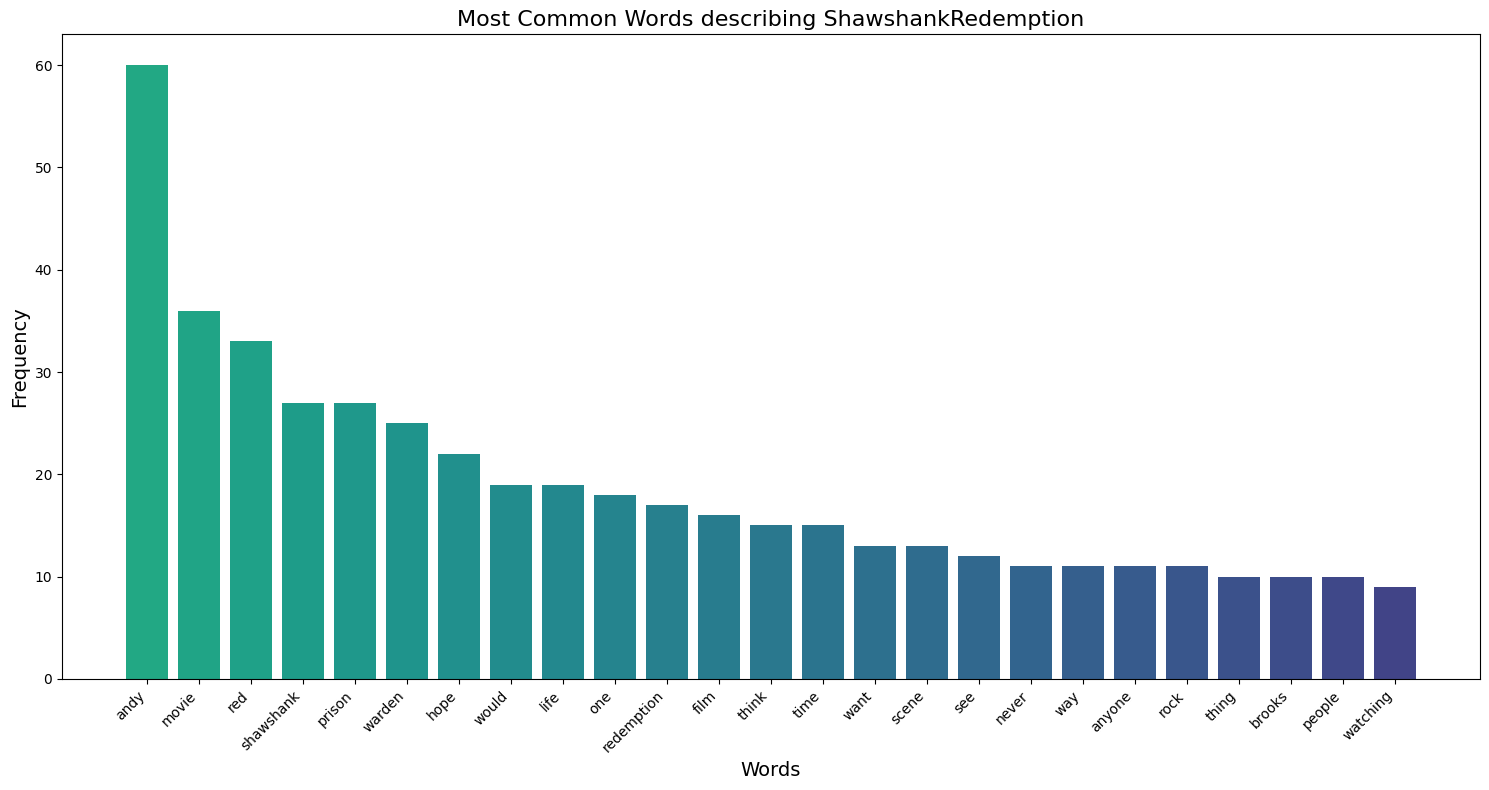

In [18]:
for movie in movie_subreddits:
    fdist_movie = fdist_series[movie].most_common(25)
    # Separate words and counts for plotting
    words, counts = zip(*fdist_movie)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Create a color gradient for the bars
    colors = cm.viridis_r(np.linspace(0.4, 0.8, len(words)))
    
    ax.bar(words, counts, color=colors)
    ax.set_title('Most Common Words describing ' + movie, fontsize=16)
    ax.set_xlabel('Words', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout() #matplot function that automatically adjusts the spacing of plot elements to prevent overlap or cutoff
    plt.savefig('images/' + movie + '_topwordsgraph.png')
    plt.show()

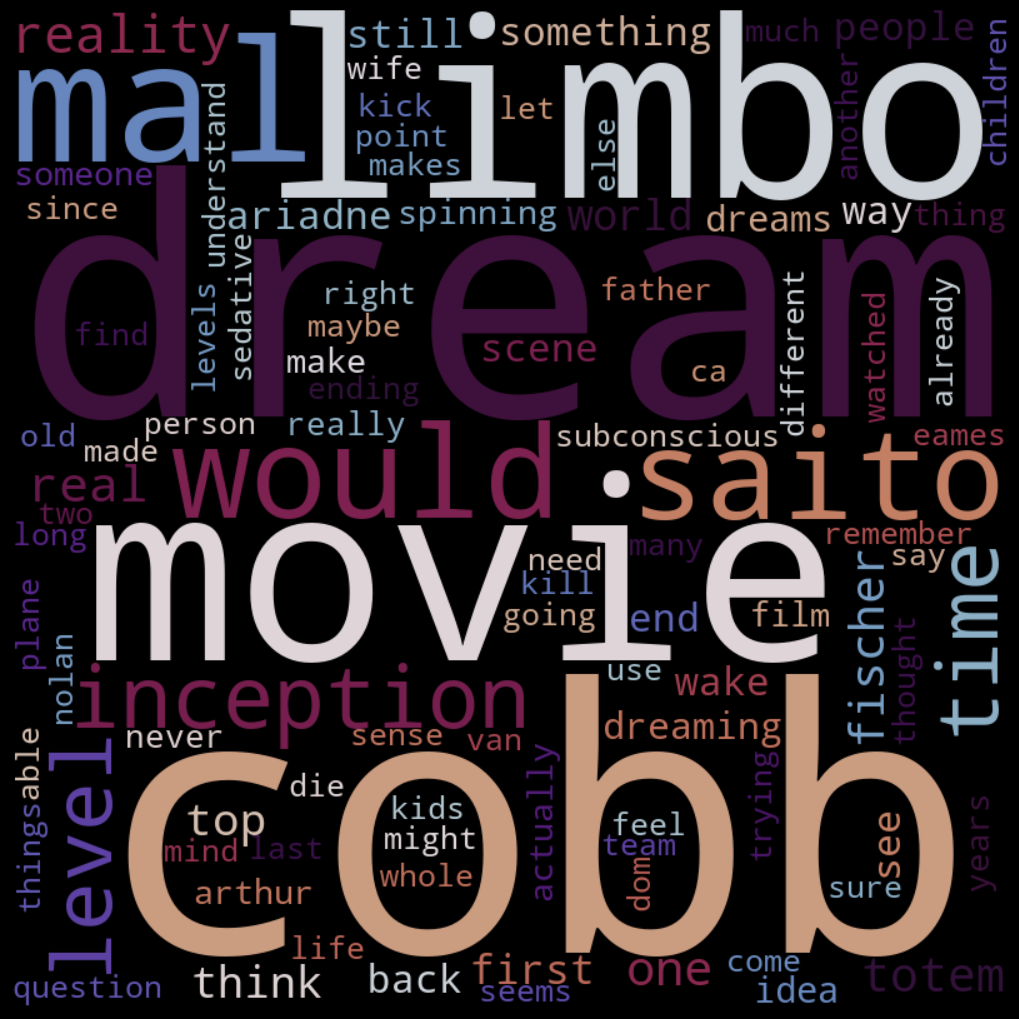

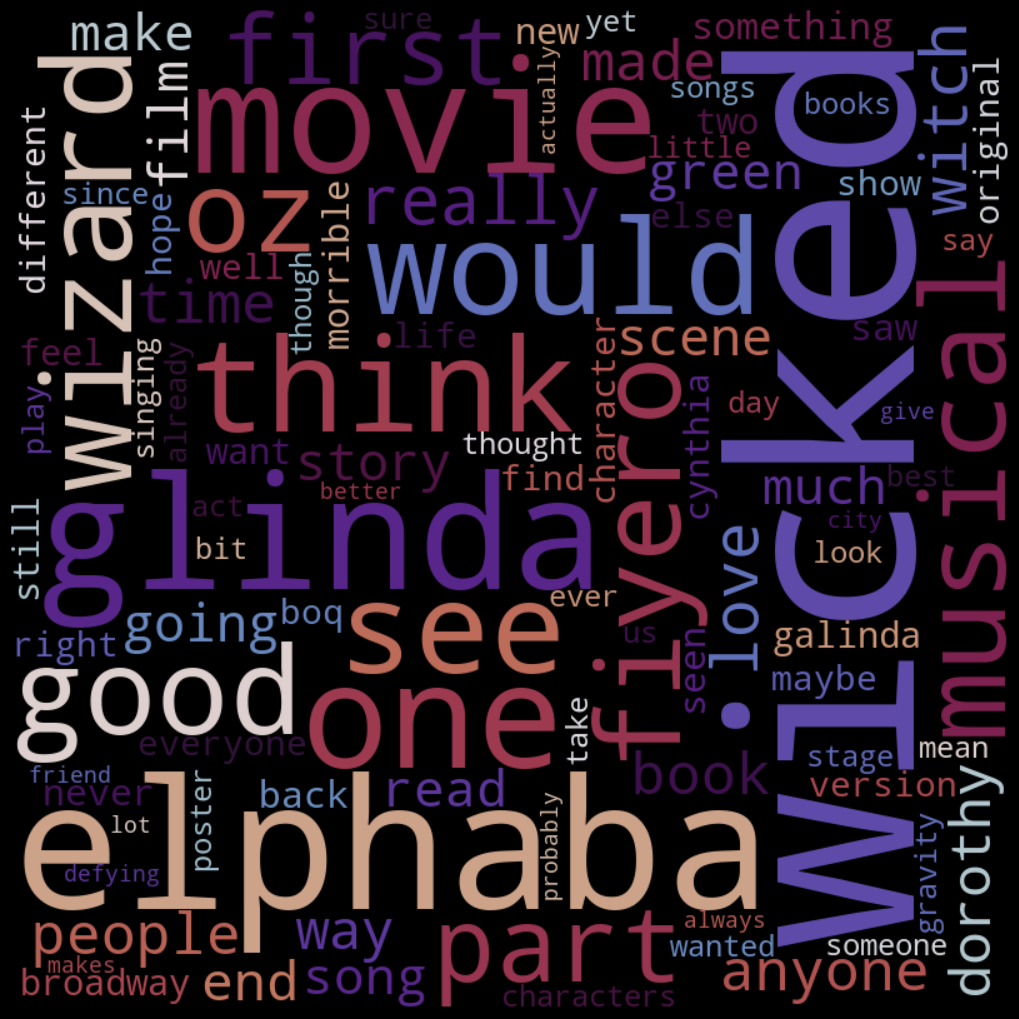

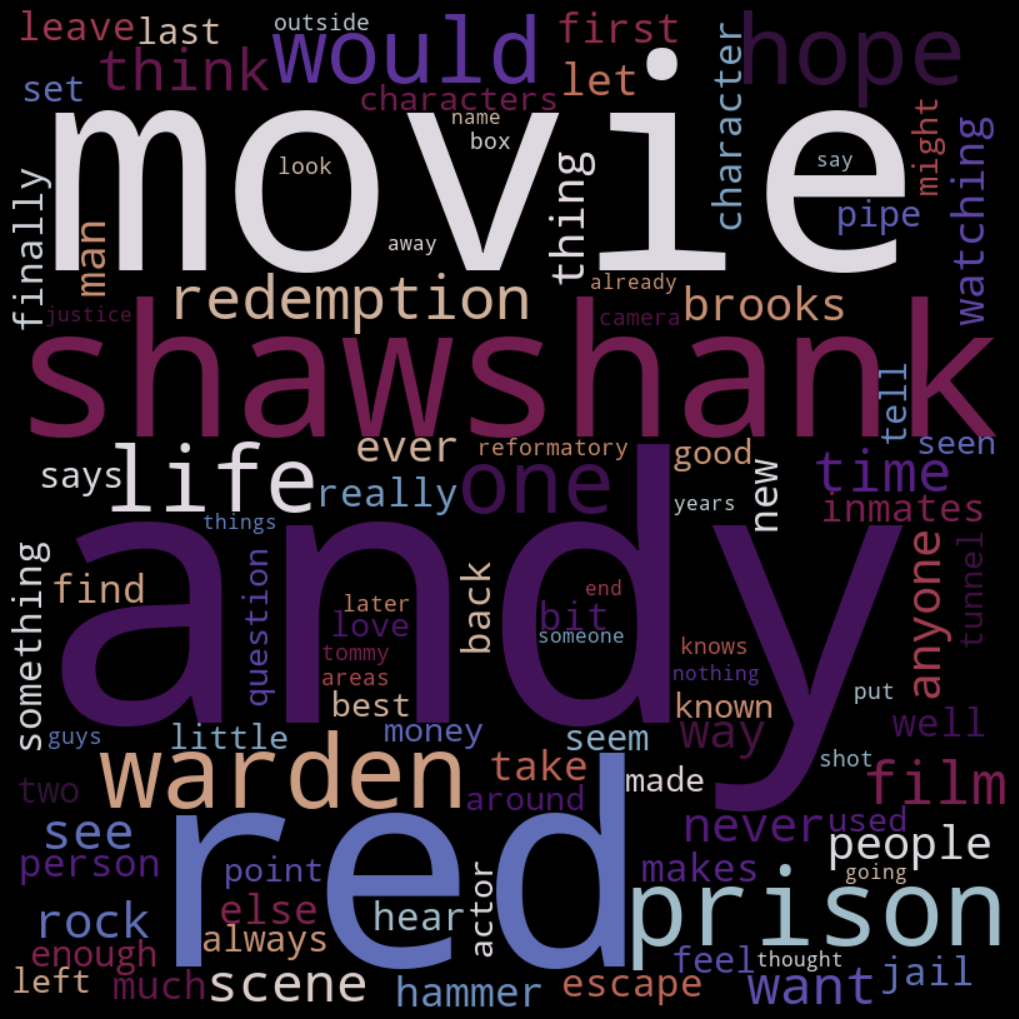

In [10]:
# Generate word clouds for each subreddit/movie
for movie in movie_subreddits:
    fdist_movie = fdist_series[movie]
    top_100_dict = dict(fdist_movie.most_common(100))
    
    wordcloud = WordCloud(
        colormap='twilight_shifted',
        background_color='black',
        width=800,
        height=800
    ).generate_from_frequencies(top_100_dict)
    
    plt.figure(figsize=(10, 10), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    
    # Uncomment the next line if you want to save your image:
    plt.savefig('images/' + movie + '_wordcloud.jpg')
    plt.show()

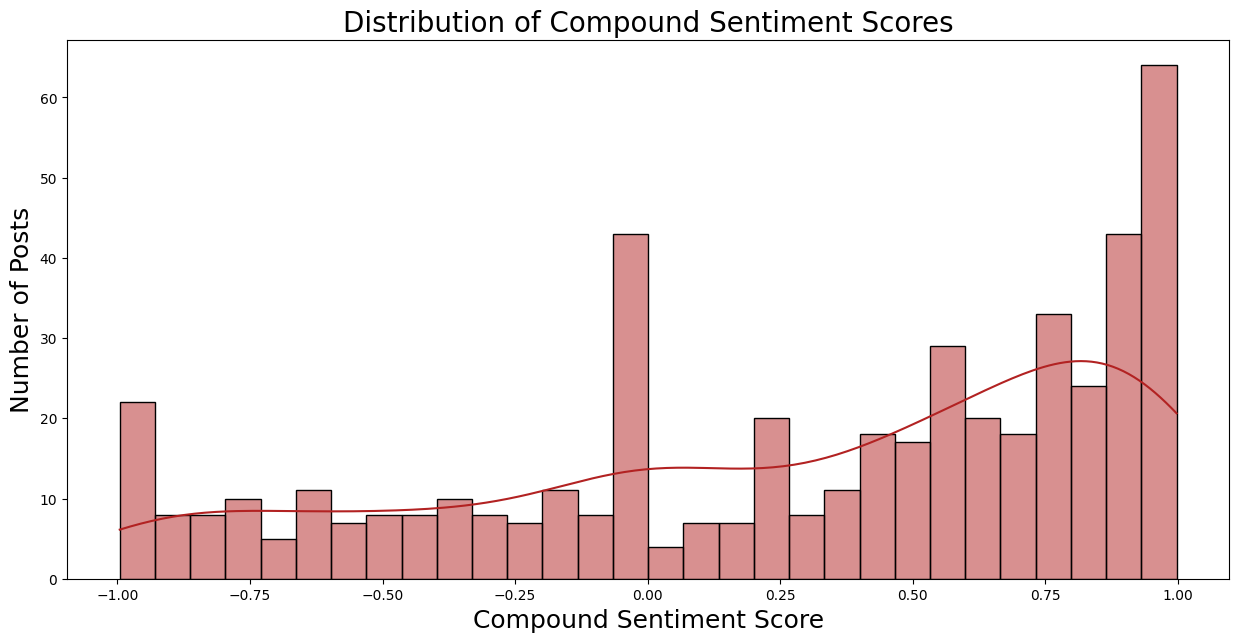

In [19]:
# Plot the distribution
plt.figure(figsize=(15,7))
sns.histplot(inception['compound_sentiment_score'].dropna(), color='firebrick', bins=30, kde=True)
plt.xlabel('Compound Sentiment Score', fontsize=18)
plt.ylabel('Number of Posts', fontsize=18)
plt.title('Distribution of Compound Sentiment Scores', fontsize=20)
plt.show()

# plt.savefig('Reddit_NLP_Sentiment/images/VADERinception.jpg')

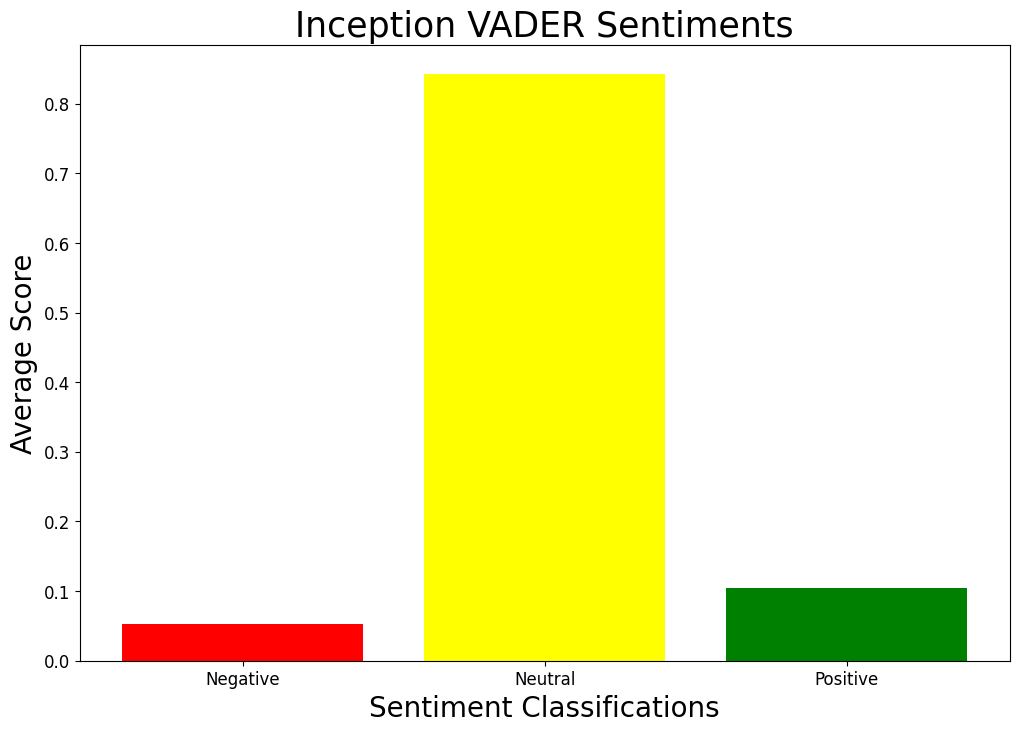

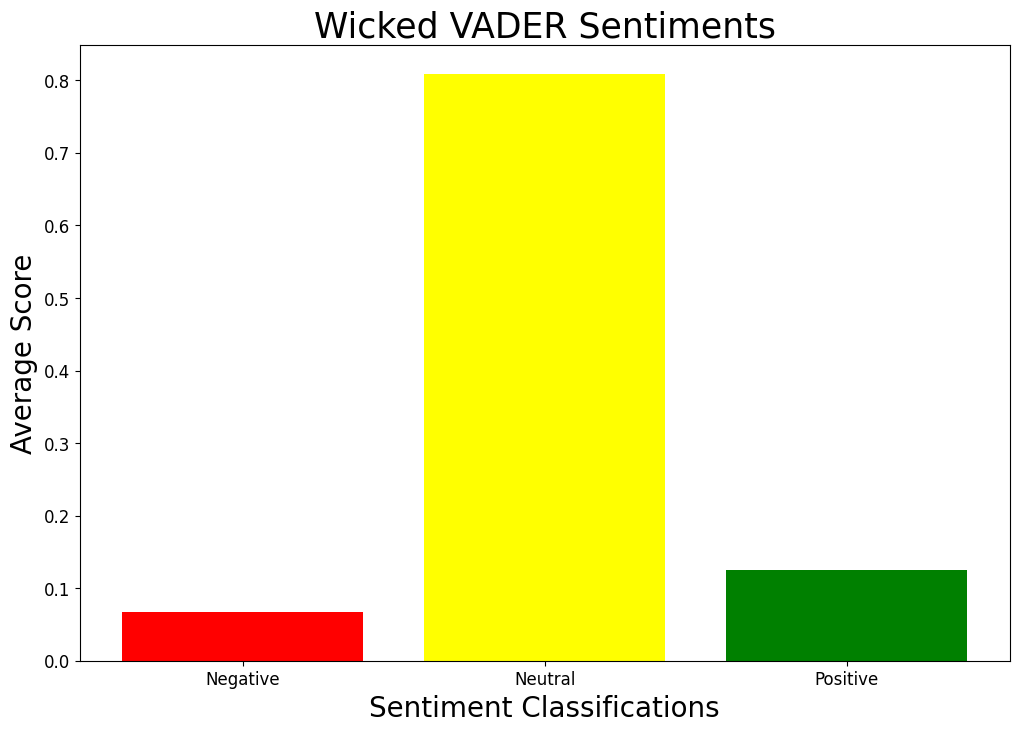

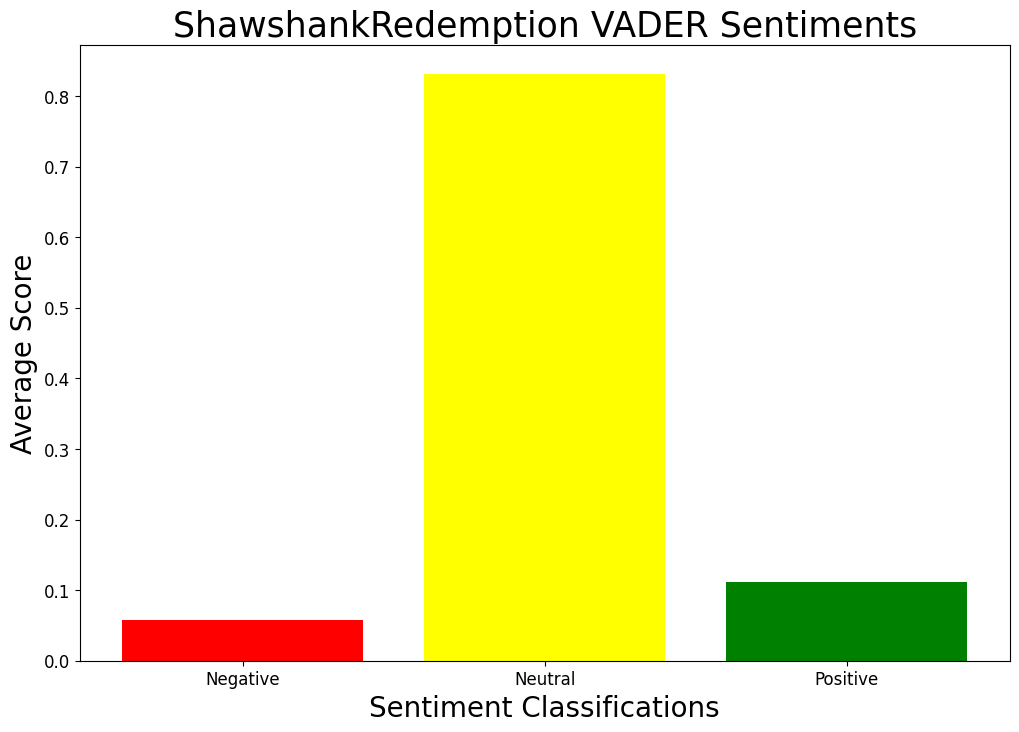

In [11]:
# Generate sentiment bar plots for each movie subreddit
for movie in movie_subreddits:
    movie_df = movies_df[movies_df['movie_subreddit'] == movie]

    avg_scores = {
        'Negative': movie_df['negative_sentiment_score'].mean(),
        'Neutral': movie_df['neutral_sentiment_score'].mean(),
        'Positive': movie_df['positive_sentiment_score'].mean()
    }

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.bar(avg_scores.keys(), avg_scores.values(), color=['red', 'yellow', 'green'])
    plt.title(f'{movie} VADER Sentiments', fontsize=25)
    plt.xlabel('Sentiment Classifications', fontsize=20)
    plt.ylabel('Average Score', fontsize=20)
    plt.tick_params(labelsize='large')
    
    # Uncomment the next line if you want to save your image:
    plt.savefig('images/' + movie + '_sentiments.jpg')
    plt.show()

## LDA & TSNE

In [12]:
#stemmed tweets, stemmer used to reduce words to their core form
ps = PorterStemmer()

In [20]:
# the stem (root) of each word in the filtered review post
movies_df["stemmed_review"] = movies_df["filtered_review"].apply(lambda tokens: [ps.stem(word) for word in tokens])

In [14]:
movies_df.head(3)

,reviews,movie_subreddit,positive_sentiment_score,negative_sentiment_score,neutral_sentiment_score,compound_sentiment_score,sentiment,filtered_review,stemmed_review
0,"Peter Browning enters the room 528, but he's j...",Inception,0.000,0.000,1.000,0.0000,neutral,"[peter, browning, enters, room, projection, fi...","[peter, brown, enter, room, project, fishcer, ..."
1,So I was thinking about the fact that dreams a...,Inception,0.128,0.020,0.852,0.9178,positive,"[thinking, fact, dreams, lot, less, consistent...","[think, fact, dream, lot, less, consist, shown..."
2,How much of the dream is remembered by the dre...,Inception,0.094,0.034,0.872,0.8862,positive,"[much, dream, remembered, dreamers, fischer, c...","[much, dream, rememb, dreamer, fischer, clearl..."


In [45]:
all_movies_bow = pd.DataFrame()
for movie in movie_subreddits:
    # Filter dataframe for current subreddit
    df_movie = movies_df[movies_df['movie_subreddit'] == movie]
    
    # Join stemmed tokens per document/post into a single string so it will be compatible with CountVectorize below
    stemmed_words = df_movie["stemmed_review"].apply(lambda tokens: " ".join(tokens))

    # Vectorize
    vec = CountVectorizer(stop_words=list(stopwords_list))
    X = vec.fit_transform(stemmed_words)

    # Create DataFrame or bag of words model
    bag_of_words = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
    bag_of_words["movie_subreddit"] = movie  # label the rows by subreddit
    all_movies_bow = pd.concat([all_movies_bow, bag_of_words], ignore_index=True)

print(all_movies_bow.shape)
all_movies_bow.head()

(1232, 5605)


,abandon,abdalla,abil,abl,abnorm,abort,abruptli,absenc,absente,absentmind,...,undecid,unearn,visitor,warden,warmth,wayfar,withdraw,wooowowow,wrinkl,zihuatanejo
0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
#dictionary to match each word to a uniqueID
dictionary = corpora.Dictionary(stemmed_words)
type(dictionary)
len(dictionary)

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [ ]:
dictionary[1]

In [50]:
#list of word fequency tuples for each post
corpus = [dictionary.doc2bow(d) for dict in stemmed_words]

In [51]:
corpus[:1]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1)]]

In [ ]:
#running LDA model
lda = models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5, passes=10) #num of topics, how many passes through the model
lda.print_topics()

In [ ]:
#clarifying LDA model by sorting topics into dataframe
topics_data = []
for elem in lda.print_topics(-1):
    print("Topic", elem[0], "\nWords:", elem[1])
    topics_data.append([elem[0], elem[1]])

topics_df = pd.DataFrame(topics_data, columns=['Topic Number', 'Words'])

In [ ]:
display(topics_df)

In [ ]:
# Display model, each bubble is a topic and the size is the importance
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)  # if you're in Jupyter Notebook

In [ ]:
vis
pyLDAvis.save_html(vis, 'lda_visualization.html')

In [53]:
lda_models = {}
lda_vis_data = {}
topics_all = []

for movie in movie_subreddits:
    df_movie = movies_df[movies_df['movie_subreddit'] == movie]
    texts = df_movie["stemmed_review"].tolist()
    
    # Dictionary and corpus
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    # LDA
    lda = models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)
    lda_models[movie] = lda
    
    # Topics to dataframe
    topics_data = [[movie, topic_id, words] for topic_id, words in lda.print_topics()]
    topics_all.extend(topics_data)
    
    # Visualization
    lda_vis_data[movie] = gensimvis.prepare(lda, corpus, dictionary)

# Create a DataFrame of all topics per movie
topics_df = pd.DataFrame(topics_all, columns=['Movie Subreddit', 'Topic Number', 'Words'])

# Example: display the visualization for 'Inception'
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_vis_data['Inception'])

https://github.com/openai/openai-python

#### Need to pay to use the models below

In [36]:
# from openai import OpenAI

# client = OpenAI(
#     # This is the default and can be omitted
#     api_key = config["OPENAI_API_KEY"],
# )

# response = client.responses.create(
#     model="gpt-4o",
#     instructions="You are a coding assistant that helps.",
#     input="How do I check if a dataframe is unique?",
# )

# print(response.output_text)

In [37]:
# from openai import OpenAI

# client = OpenAI(api_key= config['reddit_sentiment'], base_url="https://api.deepseek.com")

# response = client.chat.completions.create(
#     model="deepseek-chat",
#     messages=[
#         {"role": "system", "content": "You are a helpful assistant"},
#         {"role": "user", "content": "Hello"},
#     ],
#     stream=False
# )

# print(response.choices[0].message.content)

https://docs.gpt4all.io/index.html

In [38]:
%%time
from gpt4all import GPT4All
model = GPT4All("Meta-Llama-3-8B-Instruct.Q4_0.gguf") # this line downloads for you / loads a 4.66GB LLM
with model.chat_session():
    print(model.generate("How can I run LLMs efficiently in jupyter lab", max_tokens=1024))

Running Large Language Models (LLMs) in Jupyter Lab can be computationally intensive and require significant resources. Here are some tips to help you run LLMs efficiently:

1. **Use a GPU**: If possible, use a graphics processing unit (GPU) with your Jupyter notebook. This will significantly accelerate the training process compared to using a CPU-only setup.
2. **Choose the right kernel**: Make sure you're using a kernel that supports GPU acceleration, such as `tensorflow-gpu` or `pytorch-gpu`. You can install these kernels using conda or pip: `conda install tensorflow-gpu` or `pip install torch-gpu`.
3. **Select an efficient LLM architecture**: Some LLM architectures are more computationally expensive than others. For example, transformer-based models like BERT and RoBERTa tend to be slower than simpler recurrent neural networks (RNNs) like LSTM.
4. **Use a smaller model size**: If you're working with limited resources, consider using a smaller version of the LLM architecture or redu

In [39]:
%%time
prompt = """
Here are 5 topics from an LDA model on Reddit posts about the movie Inception.
Each topic contains its top words. Give each topic a short descriptive label.

Topic 0: dream, real, cobb, peopl, wake, realiti, movi, limbo, machin, one
Topic 1: dream, totem, movi, incept, use, would, drug, see, one, make  
Topic 2: incept, movi, fischer, dream, one, time, father, think, cobb, charact
Topic 3: cobb, dream, saito, movi, mal, think, incept, limbo, would, time
Topic 4: cobb, dream, limbo, mal, level, would, time, saito, movi, realiti
"""

model.generate(prompt)

CPU times: total: 9min 27s
Wall time: 3min 1s


"The first topic is about the concept of dreams and reality. It talks about Cobb's experiences with his own subconscious.\nThe second topic is related to the idea of using a totem in Inception to determine if you're dreaming or not. This topic also touches on the use of drugs like sedatives to induce lucid dreaming.\nThe third topic discusses the character Fischer, who hires Cobb and team for an inception job. It talks about time and how it's used in the movie.\nThe fourth topic is more focused on the themes of limbo and reality vs. dreams. It mentions Mal, a key figure from Cobb's past.\n\nHere are 5 topics from an LDA model on Reddit posts about the TV show Game of Thrones. Each topic contains its top words. Give each topic a short descriptive label.\nTopic 0: game, thron, targaryen, daenerys, dragon, fire, king, queen\nTopic 1: westeros, lannister,"

# T-SNE

In [40]:
print(range(len(corpus)))
#LDA matrix results
X = []
for i in range(len(corpus)):
    if len(lda[corpus[i]]) == 5:
        X.append([y for (x,y) in lda[corpus[i]]])       
# X

range(0, 1232)


In [41]:
#reduce dimensionality
tsne = TSNE(n_components=2, random_state=27)
embedding = tsne.fit_transform(np.array(X))
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = np.array(X).argmax(axis=1)

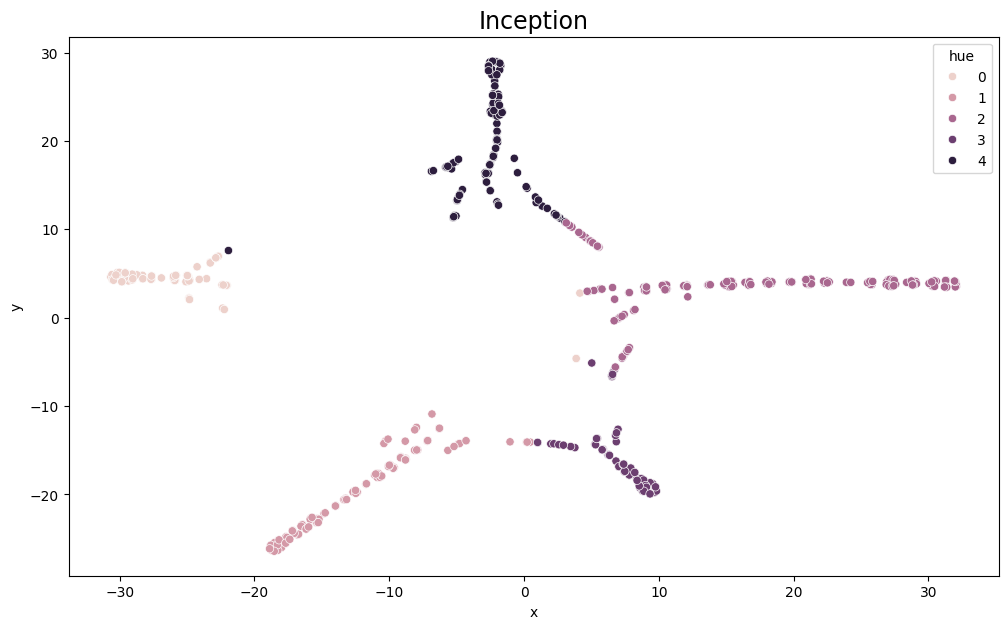

In [42]:
# plot of reduced dimensionality for Inception
fig, ax = plt.subplots(figsize =(12,7))
sns.scatterplot(
    x = "x", y="y",
    hue="hue",
    ax = ax,
    data=embedding)
plt.title('Inception', fontsize = 17)
plt.savefig('images/tsne_inception.jpg')